# RQ3 - Insertions and Removals

Uses:

- resources/seq_pattern/countpatterns_OutX_notOutx_Xlastslice.csv (from prepare/historical_seqpatterns_format.ipynb **manual**)
- Variable rq2_projects_with_dbms_history_total (from rq2/distribution.ipynb)

Generates:

- insertionsandremovals.pdf (fig:keptandremoved)

Variables:

- rq3_mysql_removal
- rq3_mysql_2nd_ins
- rq3_mysql_2nd_rem
- rq3_mysql
- rq3_mysql_once
- rq3_mysql_never_removed
- rq3_no_removals




In [1]:
import sys  
sys.path.insert(1, '..')

In [2]:
import os
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util import SEQ_PATTERNS_DIR, IMAGES_DIR
from analysis_helpers import var, relative_var, load_vars

In [3]:
size_corpus = int(load_vars()['rq2_projects_with_dbms_history_total'])

In [4]:
df4t = pd.read_csv(SEQ_PATTERNS_DIR + os.sep + "countpatterns_OutX_notOutx_Xlastslice.csv")
df4t

,Name,Support,Line Count,Bindings,Source
0,InX,1.000000,233,NaN,InX -v X
1,InMS_SQL_Server,0.287554,67,X = MS_SQL_Server,InX -v X
2,InH2,0.489270,114,X = H2,InX -v X
3,InHazelcast,0.145923,34,X = Hazelcast,InX -v X
4,InMySQL,0.587983,137,X = MySQL,InX -v X
...,...,...,...,...,...
266,$Aerospike,0.004292,1,X = Aerospike,$X -v X
267,$SapHana,0.038627,9,X = SapHana,$X -v X
268,$Impala,0.004292,1,X = Impala,$X -v X
269,$Join_Ignite_Sql,0.008584,2,X = Join_Ignite_Sql,$X -v X


In [5]:
df4t["Source"].unique()

array(['InX -v X', 'InX -> OutX -v X', 'InX -> OutX -> InX -v X',
       'InX -> OutX -> InX -> OutX -v X',
       'InX -> OutX -> InX -> OutX -> InX -v X',
       'InX -> OutX -> InX -> OutX -> InX -> OutX -v X',
       'InX -> OutX -> InX -> OutX -> InX -> OutX -> InX -v X',
       'OutX -v X', 'X ~OutX -v X', '$X -v X'], dtype=object)

In [6]:
assert len(df4t[df4t["Source"] == 'InX -> OutX -> InX -> OutX -> InX -> OutX -> InX" -v X + "InX -> OutX -> InX -> OutX -> InX -> OutX -> InX -> OutX -v X']) == 0, "Should be 0. Otherwise, we need to look for more patterns"
assert len(df4t[df4t["Source"] == 'InX -> OutX -> InX -> OutX -> InX -> OutX -> InX" -v X + "InX -> OutX -> InX -> OutX -> InX -> OutX -> InX -> OutX -v X']) == 0, "Paper: 'No projects in our corpus had more than 4 insertions or more than 3 removals.'"


Identify databases from patterncounter bindings

In [7]:
df4 = df4t[~df4t["Bindings"].isnull()].copy()
df4.loc[:,"Databases"] = df4["Bindings"].str.replace("X = ", "")
df4['Databases'].replace({'Join_Ignite': 'Ignite'}, regex=True, inplace=True)
df4['Databases'].replace({'GoogleCloudFilestore': 'GoogleCloudFirestore'}, regex=True, inplace=True)
df4

,Name,Support,Line Count,Bindings,Source,Databases
1,InMS_SQL_Server,0.287554,67,X = MS_SQL_Server,InX -v X,MS_SQL_Server
2,InH2,0.489270,114,X = H2,InX -v X,H2
3,InHazelcast,0.145923,34,X = Hazelcast,InX -v X,Hazelcast
4,InMySQL,0.587983,137,X = MySQL,InX -v X,MySQL
5,InIBM_DB2,0.175966,41,X = IBM_DB2,InX -v X,IBM_DB2
...,...,...,...,...,...,...
266,$Aerospike,0.004292,1,X = Aerospike,$X -v X,Aerospike
267,$SapHana,0.038627,9,X = SapHana,$X -v X,SapHana
268,$Impala,0.004292,1,X = Impala,$X -v X,Impala
269,$Join_Ignite_Sql,0.008584,2,X = Join_Ignite_Sql,$X -v X,Ignite_Sql


Rename values to meaningful ones

In [8]:
df4['Source'].replace({'InX -v X':'insertion:1'}, inplace=True)
df4['Source'].replace({'InX -> OutX -v X':'removal:1'}, inplace=True)
df4['Source'].replace({'InX -> OutX -> InX -v X':'insertion:2'}, inplace=True)
df4['Source'].replace({'InX -> OutX -> InX -> OutX -v X':'removal:2'}, inplace=True)
df4['Source'].replace({'InX -> OutX -> InX -> OutX -> InX -v X':'insertion:3'}, inplace=True)
df4['Source'].replace({'InX -> OutX -> InX -> OutX -> InX -> OutX -v X':'removal:3'}, inplace=True)
df4['Source'].replace({'InX -> OutX -> InX -> OutX -> InX -> OutX -> InX -v X':'insertion:4'}, inplace=True)
df4['Source'].replace({'OutX -v X':'Removed'}, inplace=True)
df4['Source'].replace({'X ~OutX -v X':'Never-removed'}, inplace=True)
df4['Source'].replace({'$X -v X':'Last'}, inplace=True)
df4.rename(columns={'Line Count': 'Lines'}, inplace=True)

df4

,Name,Support,Lines,Bindings,Source,Databases
1,InMS_SQL_Server,0.287554,67,X = MS_SQL_Server,insertion:1,MS_SQL_Server
2,InH2,0.489270,114,X = H2,insertion:1,H2
3,InHazelcast,0.145923,34,X = Hazelcast,insertion:1,Hazelcast
4,InMySQL,0.587983,137,X = MySQL,insertion:1,MySQL
5,InIBM_DB2,0.175966,41,X = IBM_DB2,insertion:1,IBM_DB2
...,...,...,...,...,...,...
266,$Aerospike,0.004292,1,X = Aerospike,Last,Aerospike
267,$SapHana,0.038627,9,X = SapHana,Last,SapHana
268,$Impala,0.004292,1,X = Impala,Last,Impala
269,$Join_Ignite_Sql,0.008584,2,X = Join_Ignite_Sql,Last,Ignite_Sql


## Removed and Never Removed

In [9]:
df5 = df4[
    (df4['Source'] == 'Removed')
    | (df4['Source'] == 'Never-removed')
].copy()
df5.rename(columns={'Lines': 'Amount of Projects', 'Source':'Legend'}, inplace=True)
df5 = df5.sort_values(['Amount of Projects'], ascending=[False])
df5 = df5[['Databases', 'Legend', 'Amount of Projects']].copy()
df5

,Databases,Legend,Amount of Projects
182,MySQL,Never-removed,96
180,H2,Never-removed,82
186,PostgreSQL,Never-removed,77
184,Oracle,Never-removed,71
190,Redis,Never-removed,68
...,...,...,...
176,Aerospike,Removed,1
171,ArangoDB,Removed,1
168,Snowflake,Removed,1
167,Influx_DB,Removed,1


### _Display Removed and Never Removed Based on All Corpus

(Not used in the paper)

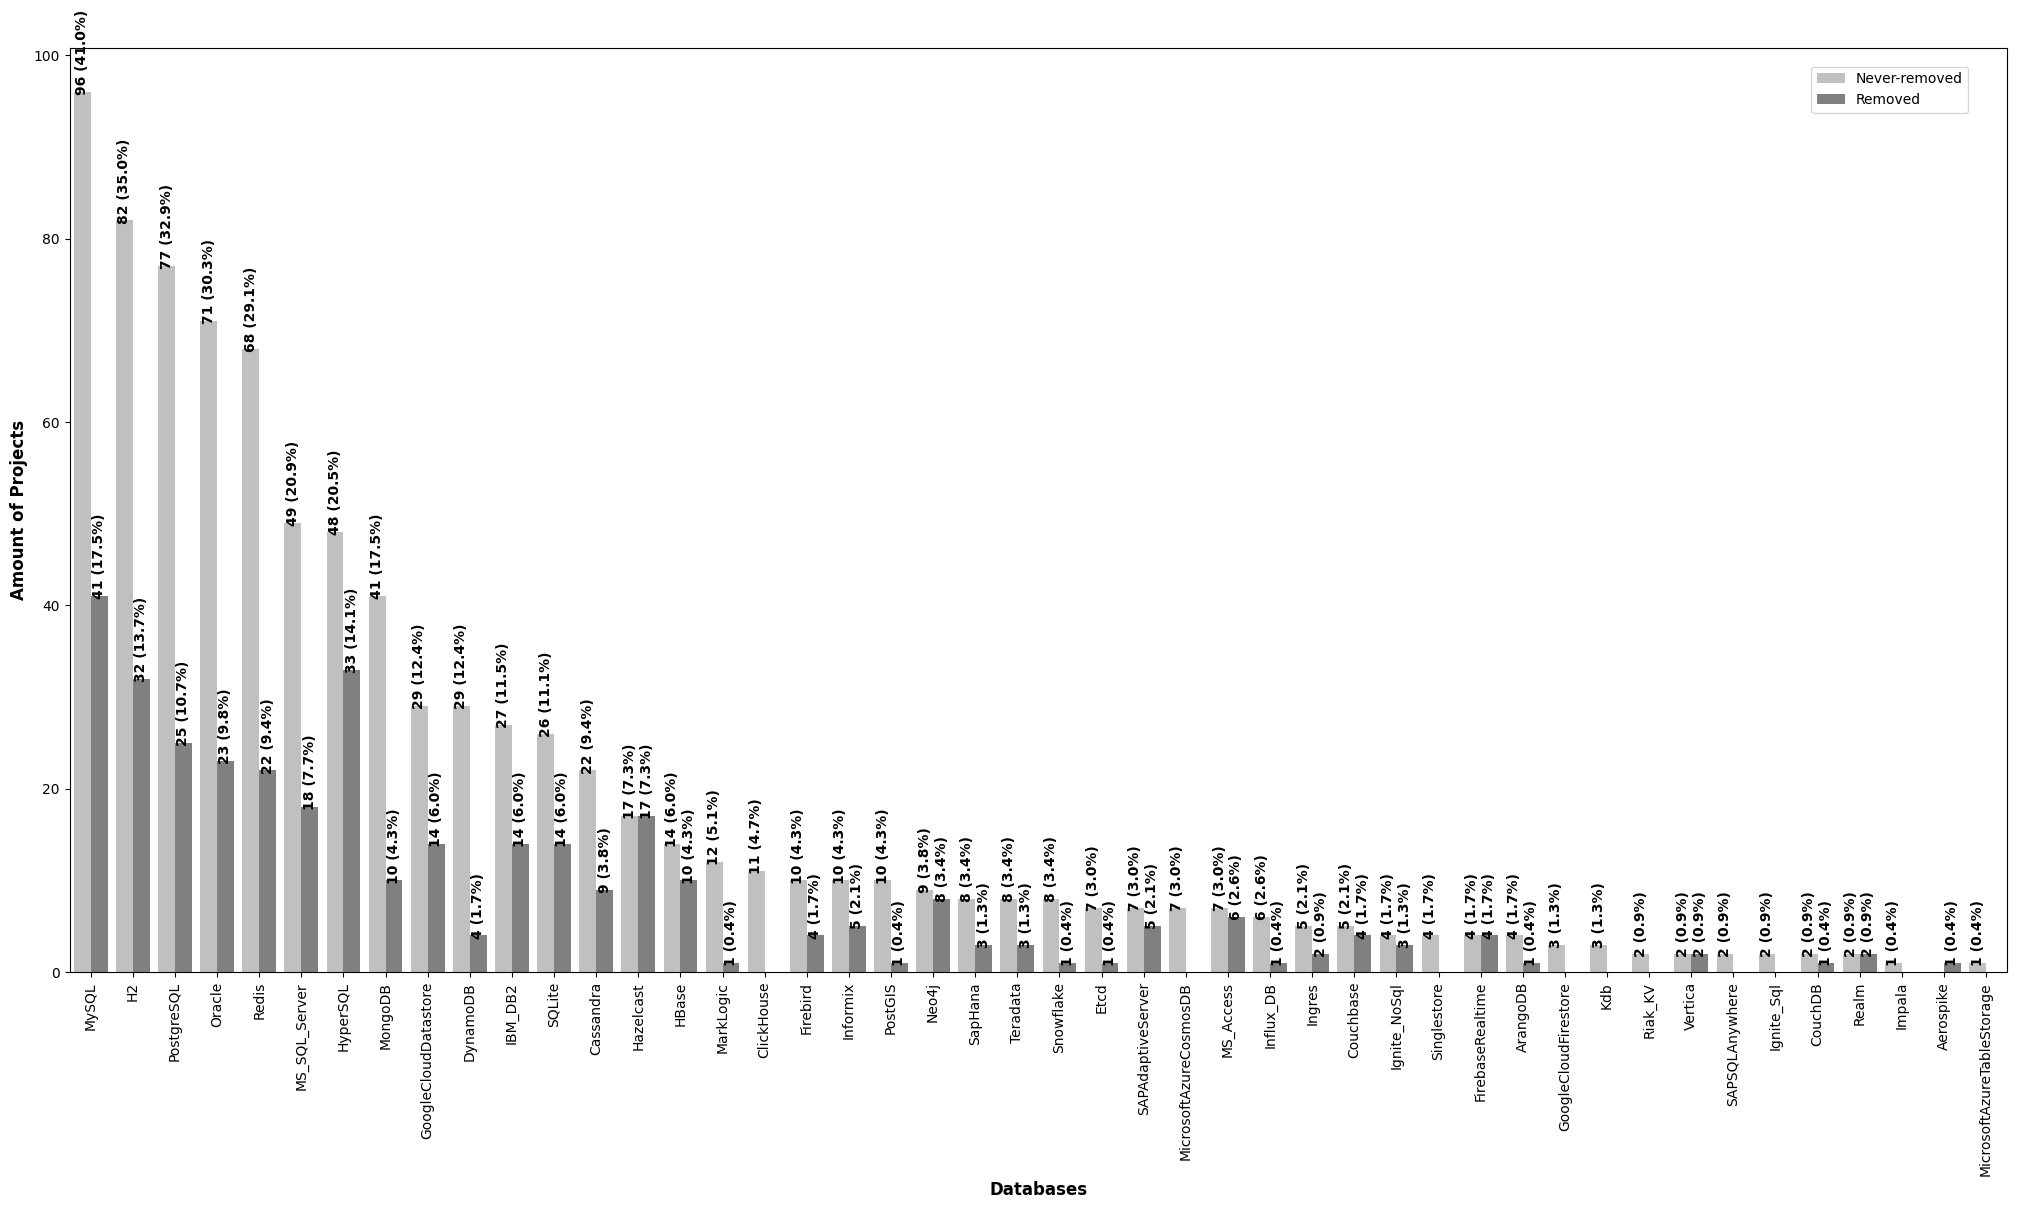

In [10]:
plt.figure(figsize=(25, 12))

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            if np.isnan(_x) or np.isnan(_y):
                continue
            height = p.get_height()
            percent = 100 * height / size_corpus
            #value = '{:.1f}'.format(percent)
            value = '{:.0f} ({:.1f}%)'.format(height, percent)
            ax.text(_x, _y, value, ha="center", fontsize = 10, fontweight='bold', rotation=90)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
# create grouped bar chart
p = sns.barplot(x='Databases', y='Amount of Projects', hue='Legend', data=df5, palette=["Silver", "gray"])

# add axis titles
plt.xlabel('Databases', fontsize=12, fontweight='bold')
plt.ylabel('Amount of Projects', fontsize=12, fontweight='bold')

# add values to bars
show_values_on_bars(p)

# add legend
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0.)

# rotate x-axis labels
plt.xticks(rotation=90)
#plt.yticks(range(0, 30, 10), fontsize=12)

#plt.savefig(IMAGES_DIR+"/projects_keptandremoved3.pdf", format="pdf", bbox_inches="tight")
# show plot
plt.show()

### _Display Removed and Never Removed with Relative Percentages

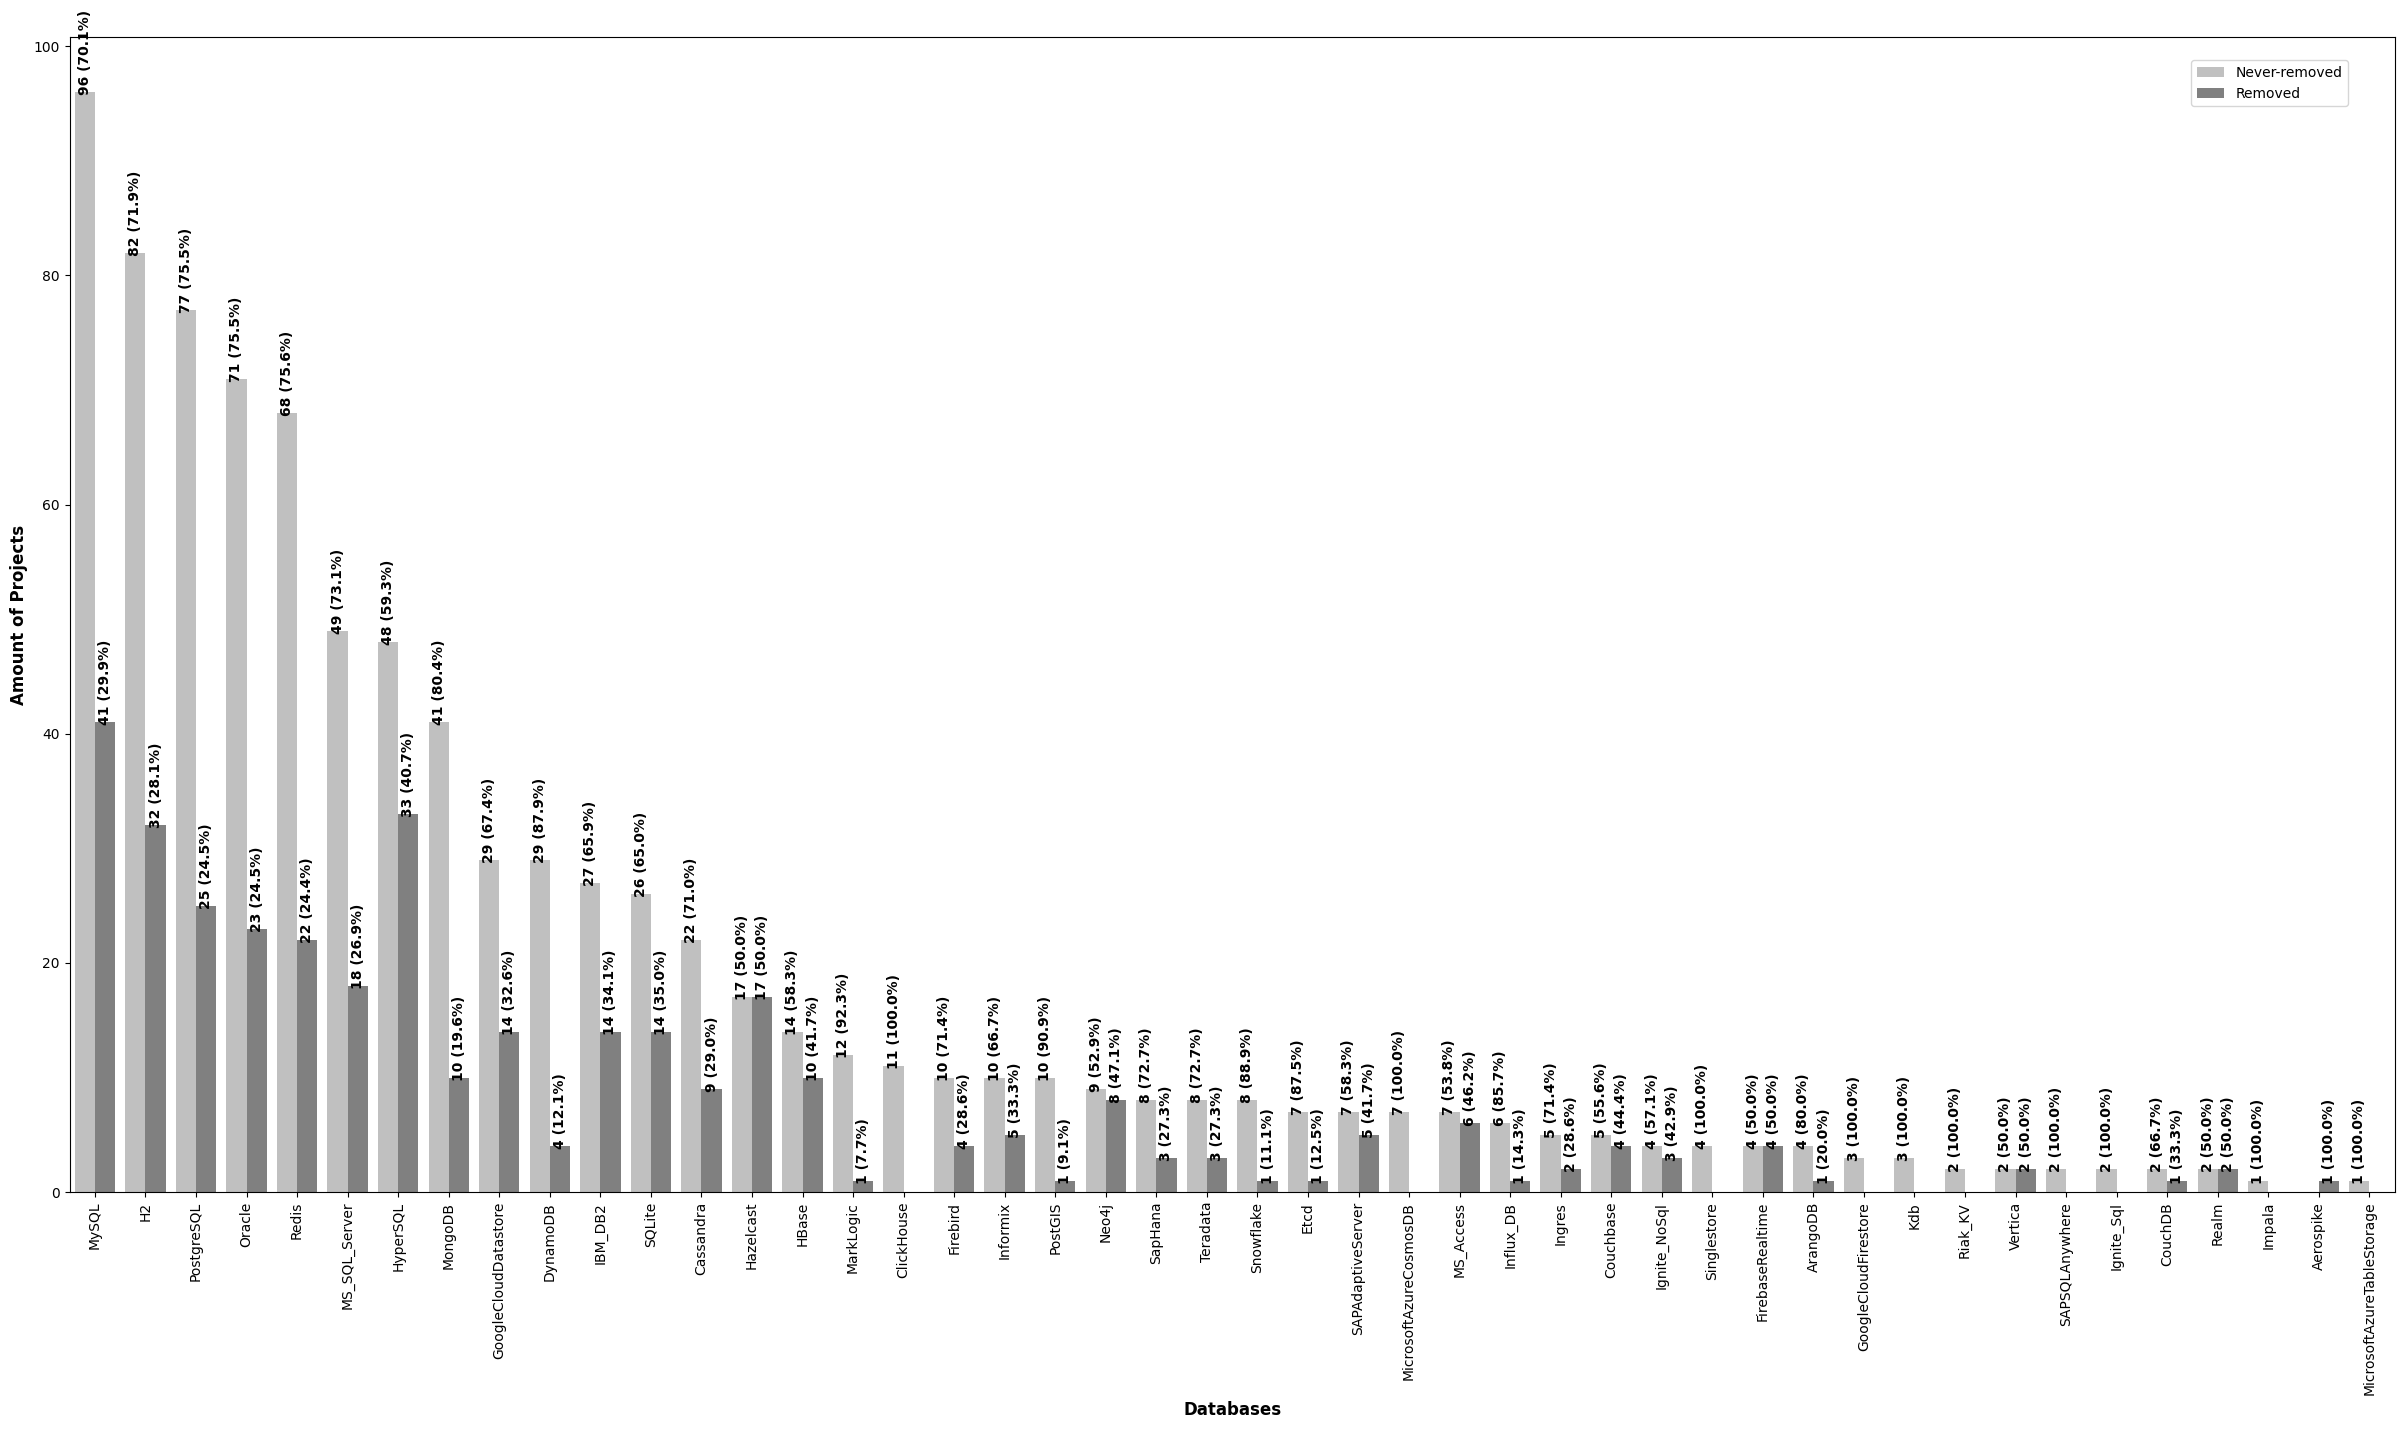

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Exemplo de DataFrame (ajuste conforme seus dados)

plt.figure(figsize=(30, 15))

def show_values_on_bars(axs, df):
    def _show_on_single_plot(ax):
        # Iterar sobre as barras
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2  # Posição no eixo X (meio da barra)
            _y = p.get_y() + p.get_height()  # Posição Y para a colocação do texto
            if np.isnan(_x) or np.isnan(_y):
                continue
            height = p.get_height()

            # Obter o nome do banco de dados (Databases) a partir do eixo X
            label = p.get_x()  # Posição no eixo X (deve ser o nome do banco de dados)
            
            # Associar a posição do eixo X com o nome do banco
            # Agora, estamos usando o valor da coluna 'Databases' para pegar o nome correto
            #xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]
            #label = xticklabels[int(label)]

            # Supondo que os rótulos do eixo X correspondem a um intervalo de índices
            xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

            # Se p.get_x() não for um índice exato, podemos fazer uma busca pelo valor mais próximo
            x_pos = p.get_x()

            # Encontrar o índice mais próximo
            closest_idx = min(range(len(xticklabels)), key=lambda i: abs(x_pos - i))

            # Agora, podemos usar o índice para pegar o nome correspondente
            label = xticklabels[closest_idx]

            
            #database_name = df['Databases'].iloc[int(label)].replace(' ', '')  # Ajustar para garantir que não há espaços

            # Calcular o total para esse banco de dados (Removed + Kept)
            total_height = df[df['Databases'] == label]['Amount of Projects'].sum()

            # Verificação para evitar a divisão por zero
            if total_height == 0:
                percent = 0  # Se o total for zero, define o percentual como zero
            else:
                percent = 100 * height / total_height  # Calcula a porcentagem da barra

            # Formatar a exibição do valor: valor absoluto e percentual
            value = '{:.0f} ({:.1f}%)'.format(height, percent)
            ax.text(_x, _y, value, ha="center", fontsize=10, fontweight='bold', rotation=90)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


# Criar o gráfico de barras agrupadas
p = sns.barplot(x='Databases', y='Amount of Projects', hue='Legend', data=df5, palette=["Silver", "gray"])

# Adicionar títulos aos eixos
plt.xlabel('Databases', fontsize=12, fontweight='bold')
plt.ylabel('Amount of Projects', fontsize=12, fontweight='bold')

# Adicionar valores às barras
show_values_on_bars(p, df5)

# Adicionar legenda
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0.)

# Rotacionar os rótulos do eixo X
plt.xticks(rotation=90)

# Salvar o gráfico em PDF
#plt.savefig(IMAGES_DIR+"/projects_keptandremoved3.pdf", format="pdf", bbox_inches="tight")

# Exibir o gráfico
plt.show()


### Display Insertions and Removals

fig:keptandremoved

Create dataframe that only contains insertion and removal patterns

In [12]:
df5t = df4[
    (df4['Source'] != 'Last')
    & (df4['Source'] != 'Removed')
    & (df4['Source'] != 'Never-removed')
].copy()
df5t[['Operation', 'Count']] = df5t['Source'].str.split(':', n=1, expand=True)
df5t.rename(columns={'Lines': 'Amount of Projects', 'Source':'Legend'}, inplace=True)
df5t = df5t.sort_values(['Amount of Projects'], ascending=[False])
df5t = df5t[['Databases', 'Operation', 'Count', 'Amount of Projects']].copy()
df5t

,Databases,Operation,Count,Amount of Projects
4,MySQL,insertion,1,137
2,H2,insertion,1,114
8,PostgreSQL,insertion,1,102
6,Oracle,insertion,1,94
12,Redis,insertion,1,90
...,...,...,...,...
105,Aerospike,insertion,2,1
106,SapHana,insertion,2,1
108,MS_SQL_Server,removal,2,1
111,IBM_DB2,removal,2,1


Separate insertion and removal dataframes with columns indicating the counts.

The values in the original dataframe is cumulative: count=1 includes count=2, count=3, ...
The new separated dataframe has non-cumulative values

In [13]:
dbs = set(df5t['Databases'].tolist())
op_dfs = {}
for op, odf in df5t.set_index('Databases').groupby("Operation"):
    series = {}
    for count, cdf in odf.groupby('Count'):
        series[count] = cdf['Amount of Projects']
    op_df = pd.DataFrame(series).fillna(0)
    gdbs = set(op_df.index.tolist())
    for db in dbs - gdbs:
        op_df.loc[db] = 0
    for c2 in range(len(op_df.columns), 1, -1):
        for c in range(1, c2):
            op_df.loc[:,str(c)] = op_df.loc[:,str(c)] - op_df.loc[:,str(c2)]
    op_dfs[op] = op_df.sort_values(by='1', ascending=False)
    
op_dfs['removal'] = op_dfs['removal'].reindex(op_dfs['insertion'].index)
        

In [14]:
never_removed = df4[
  (df4['Source'] == 'Never-removed')
][['Databases','Lines']].copy().set_index("Databases").rename(columns={'Lines': 'Never-Removed'})
op_dfs['insertion'].insert(0, 'Never-removed', 0)
op_dfs['insertion']['Never-removed'] = never_removed
op_dfs['insertion']['Never-removed'].fillna(0, inplace=True)
op_dfs['insertion']["1"] -= op_dfs['insertion']['Never-removed']
op_dfs['insertion']

,Never-removed,1,2,3,4
Databases,,,,,
MySQL,96.0,21.0,20.0,0.0,0.0
H2,82.0,22.0,10.0,0.0,0.0
PostgreSQL,77.0,9.0,15.0,1.0,0.0
Oracle,71.0,13.0,8.0,1.0,1.0
Redis,68.0,9.0,12.0,1.0,0.0
HyperSQL,48.0,23.0,9.0,1.0,0.0
MS_SQL_Server,49.0,12.0,5.0,1.0,0.0
MongoDB,41.0,8.0,2.0,0.0,0.0
GoogleCloudDatastore,29.0,12.0,2.0,0.0,0.0


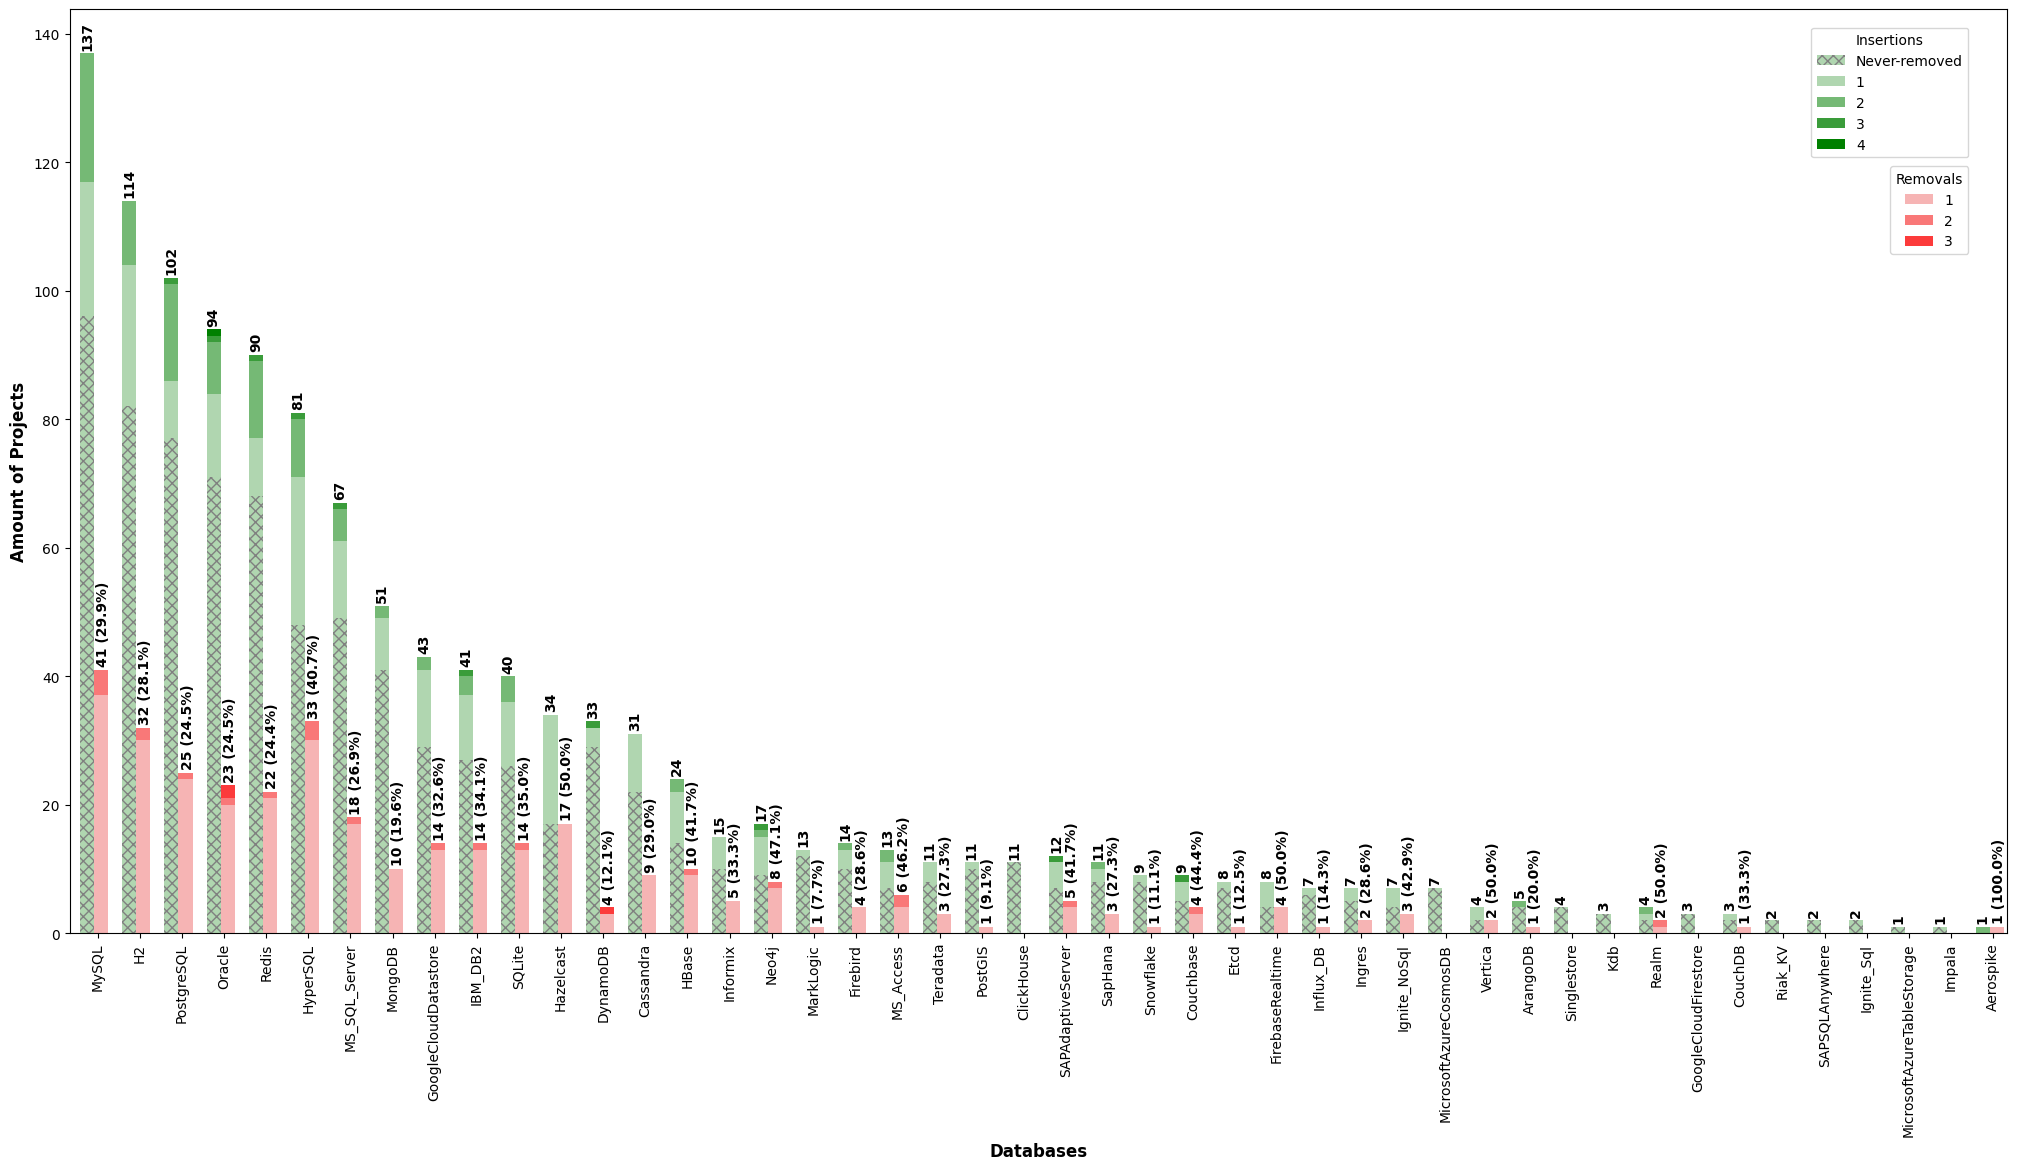

In [15]:
def plot_insertion_removal(dfall, df, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall['insertion'].columns) 
    n_ind = len(dfall['insertion'].index)
    axe = plt.subplot(111)

    visited = set()
    green_palette = sns.light_palette("green", n_colors=5)
    never_removed = green_palette[1]
    rest = green_palette[1:]
    palette = [never_removed] + rest
    sns.set_palette(palette)
    ax1 = axe = dfall['insertion'].plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)
    
    insertions = [0] * n_ind
    for c in ax1.containers:
        visited.add(id(c))
        for i, value in enumerate(c):
            if value.get_height() > 0:
                insertions[i] += int(value.get_height())
    for i, value in enumerate(ax1.containers[0]):
        value.set_edgecolor([0.5,0.5,0.5])
        value.set_hatch('xxx')    

    for i, value in enumerate(insertions):
        if not value:
            continue
        x = i - 0.08
        y = value + 1
        ax1.text(x, y, f'{value}', ha="center", fontsize=10, fontweight='bold', rotation=90)
        
    #ax1.bar_label(ax1.containers[-1], labels=insertions, label_type='edge', rotation=90)
    
    sns.set_palette(sns.light_palette("red", n_colors=5)[1:])
    ax2 = axe = dfall['removal'].plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)
    
    removals = [0] * n_ind
    for c in ax2.containers:
        if id(c) in visited:
            continue
        for i, value in enumerate(c):
            if value.get_height() > 0:
                removals[i] += int(value.get_height())
    for i, value in enumerate(removals):
        if not value:
            continue
        x = i + 0.3
        y = value + 1
        text = f'{value} ({value/insertions[i]:.1%})'
        ax1.text(x, y, text, ha="center", fontsize=10, fontweight='bold', rotation=90)           
    

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                #rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))                
        

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(dfall['removal'].index, rotation = 90)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0., title="Insertions")
    l2 = axe.legend(h[n_col:], l[n_col:], bbox_to_anchor=(0.98, 0.83), loc='upper right', borderaxespad=0., title="Removals")
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe
sns.color_palette()
plt.figure(figsize=(25, 12))
plot_insertion_removal(op_dfs, df5t)
plt.xlabel('Databases', fontsize=12, fontweight='bold')
plt.ylabel('Amount of Projects', fontsize=12, fontweight='bold')
plt.savefig(IMAGES_DIR+"/insertionsandremovals.pdf", format="pdf", bbox_inches="tight")

In [16]:
mysql_adoption = op_dfs["insertion"].sum(axis=1)['MySQL']
print(mysql_adoption)

137.0


In [17]:
mysql_removal = int(op_dfs["removal"].sum(axis=1)['MySQL'])
print("MySQL removal:", relative_var("rq3_mysql_removal", mysql_removal, mysql_adoption))

MySQL removal: 41 (29.9%)


In [18]:
second_insertion = int(op_dfs["insertion"]["2"]['MySQL'])
print("MySQL 2nd insertion:", relative_var("rq3_mysql_2nd_ins", second_insertion, mysql_adoption))

MySQL 2nd insertion: 20 (14.6%)


In [19]:
second_removal = int(op_dfs["removal"]["2"]['MySQL'])
print("MySQL 2nd removal:", relative_var("rq3_mysql_2nd_rem", second_removal, mysql_adoption))

MySQL 2nd removal: 4 (2.9%)


In [20]:
mysql_last_slice = mysql_adoption - mysql_removal + second_insertion - second_removal
print("MySQL last slice:", relative_var("rq3_mysql", mysql_last_slice, mysql_adoption))

MySQL last slice: 112.0 (81.8%)


In [21]:
mysql_extacly_only = (op_dfs["insertion"]["Never-removed"] + op_dfs["insertion"]["1"])['MySQL']
print("MySQL once:", relative_var("rq3_mysql_once", mysql_extacly_only, mysql_adoption))

MySQL once: 117.0 (85.4%)


In [22]:
never_removed = mysql_adoption - mysql_removal
print("MySQL never removed:", relative_var("rq3_mysql_never_removed", never_removed, mysql_adoption))

MySQL never removed: 96.0 (70.1%)


In [23]:
result = []
for key, value in op_dfs["insertion"][op_dfs["removal"].sum(axis=1) == 0]["Never-removed"].items():
    plural = 's' if value > 1 else ''
    result.append(f"{key} ({int(value)} project{plural})")
text = ', '.join(result[:-1]) + f", and {result[-1]}" 
print("DBMS with no removals:", var("rq3_no_removals", text))

DBMS with no removals: ClickHouse (11 projects), MicrosoftAzureCosmosDB (7 projects), Singlestore (4 projects), Kdb (3 projects), GoogleCloudFirestore (3 projects), Riak_KV (2 projects), SAPSQLAnywhere (2 projects), Ignite_Sql (2 projects), MicrosoftAzureTableStorage (1 project), and Impala (1 project)


In [24]:
assert op_dfs["insertion"]["4"]["Oracle"] == 1, "Paper: 'The removals happened for the majority of DBMSs we surveyed. Sometimes, more than once for the same project, with Oracle being removed 3 times and inserted 4 times in a single project, for instance.'"